# Expected shortfall Engines Demonstration Notebook

This notebook demonstrates the Expecte shortfall calculation engine.

We'll showcase:

1. Expected shortfall market data for a multi-asset portfolio.

In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from typing import Dict, List, Tuple, Optional
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import os, sys
import yfinance as yf

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [2]:
# Set project root path (adjust if you're deeper in the directory tree)
project_root = os.path.abspath("..")  # or two levels up if needed
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [3]:
from risk_management.expected_shortfall import ExpectedShortfallEngine
from data.data_loader import download_or_load_from_cache

In [4]:
# Initialize the engine
es_engine = ExpectedShortfallEngine(confidence_levels=[0.95, 0.99])
print("✅ Expected Shortfall Engine initialized")

✅ Expected Shortfall Engine initialized


## Portfolio Construction - Multi-Asset Institutional Portfolio

Define our investment universe. We fetch data from yfinance, and calculate returns and some annualised stats

In [5]:
tickers = {
    # Equity Exposure
    'SPY': 'US Large Cap (S&P 500)',
    'EFA': 'International Developed Markets',
    'EEM': 'Emerging Markets',
    
    # Fixed Income
    'TLT': 'Long-Term Treasury Bonds',
    'LQD': 'Investment Grade Corporate Bonds',
    
    # Alternatives
    'GLD': 'Gold',
    'VNQ': 'Real Estate (REITs)',
    
    # Currency/Dollar exposure
    'UUP': 'US Dollar Index'
}

print(f"🌍 Portfolio Universe:")
for ticker, description in tickers.items():
    print(f"  {ticker}: {description}")

🌍 Portfolio Universe:
  SPY: US Large Cap (S&P 500)
  EFA: International Developed Markets
  EEM: Emerging Markets
  TLT: Long-Term Treasury Bonds
  LQD: Investment Grade Corporate Bonds
  GLD: Gold
  VNQ: Real Estate (REITs)
  UUP: US Dollar Index


In [7]:
start_date = "2015-01-02"
end_date = "2025-05-01"
cache_dir = "../data/cache"

all_data = []

for ticker in tickers:
    df = download_or_load_from_cache(ticker, start_date, end_date, cache_dir)
    if df is not None:
        all_data.append(df)

if all_data:
    combined_data = pd.concat(all_data, axis=1)
    print("\n✅ Final Combined Data:")
    print(combined_data.head())
else:
    print("❌ No data_ingestion available from any ticker.")


🔽 Downloading SPY (attempt 1)...

🔽 Downloading EFA (attempt 1)...

🔽 Downloading EEM (attempt 1)...

🔽 Downloading TLT (attempt 1)...

🔽 Downloading LQD (attempt 1)...

🔽 Downloading GLD (attempt 1)...

🔽 Downloading VNQ (attempt 1)...

🔽 Downloading UUP (attempt 1)...

✅ Final Combined Data:
                   SPY        EFA        EEM         TLT        LQD  \
Date                                                                  
2015-01-02  172.075226  45.345898  31.087727   97.605247  84.424858   
2015-01-05  168.967590  44.275497  30.534451   99.138474  84.770065   
2015-01-06  167.376129  43.773983  30.406149  100.924683  85.115303   
2015-01-07  169.461868  44.260536  31.063667  100.725372  85.228012   
2015-01-08  172.468933  44.859352  31.592894   99.391479  84.953262   

                   GLD        VNQ        UUP  
Date                                          
2015-01-02  114.080002  54.639713  20.907145  
2015-01-05  115.800003  54.938763  20.950342  
2015-01-06  117.12

In [15]:
returns = es_engine.calculate_returns(combined_data)
print(f"✅ Returns calculated: {len(returns)} observations")
print(f"\n📊 Asset Statistics (Annualized):")
stats_df = pd.DataFrame({
    'Mean Return': returns.mean() * 252,
    'Volatility': returns.std() * np.sqrt(252),
    'Sharpe Ratio': (returns.mean() * 252) / (returns.std() * np.sqrt(252)),
    'Min Return': returns.min(),
    'Max Return': returns.max()
})
print(stats_df.round(4))

✅ Returns calculated: 2596 observations

📊 Asset Statistics (Annualized):
     Mean Return  Volatility  Sharpe Ratio  Min Return  Max Return
SPY       0.1136      0.1816        0.6255     -0.1159      0.0999
EFA       0.0607      0.1761        0.3446     -0.1164      0.0813
EEM       0.0332      0.2087        0.1590     -0.1333      0.0775
TLT      -0.0088      0.1530       -0.0576     -0.0690      0.0725
LQD       0.0235      0.0861        0.2731     -0.0513      0.0713
GLD       0.0951      0.1429        0.6653     -0.0552      0.0479
VNQ       0.0466      0.2108        0.2211     -0.1951      0.0861
UUP       0.0263      0.0733        0.3584     -0.0326      0.0371


## Portfolio Weight Assignment

In [16]:
# Institutional-style portfolio allocation
portfolio_weights = {
    'SPY': 0.30,   # 30% US Equity (core holding)
    'EFA': 0.15,   # 15% International Equity
    'EEM': 0.10,   # 10% Emerging Markets
    'TLT': 0.20,   # 20% Long-Term Bonds (duration exposure)
    'LQD': 0.15,   # 15% Corporate Bonds
    'GLD': 0.05,   # 5% Gold (inflation hedge)
    'VNQ': 0.03,   # 3% REITs (real estate exposure)
    'UUP': 0.02,   # 2% USD strength (currency hedge)
}

print(f"\n💼 Portfolio Allocation:")
for asset, weight in portfolio_weights.items():
    print(f"  {asset}: {weight:.1%} - {tickers[asset]}")

# Verify weights sum to 100%
total_weight = sum(portfolio_weights.values())
print(f"\n✅ Total allocation: {total_weight:.1%}")


💼 Portfolio Allocation:
  SPY: 30.0% - US Large Cap (S&P 500)
  EFA: 15.0% - International Developed Markets
  EEM: 10.0% - Emerging Markets
  TLT: 20.0% - Long-Term Treasury Bonds
  LQD: 15.0% - Investment Grade Corporate Bonds
  GLD: 5.0% - Gold
  VNQ: 3.0% - Real Estate (REITs)
  UUP: 2.0% - US Dollar Index

✅ Total allocation: 100.0%


## Portfolio Construction and Basic Analysis


In [18]:
portfolio_returns = es_engine.create_portfolio(returns, portfolio_weights)

# Portfolio statistics
portfolio_stats = {
    'Total Observations': len(portfolio_returns),
    'Annualized Return': portfolio_returns.mean() * 252,
    'Annualized Volatility': portfolio_returns.std() * np.sqrt(252),
    'Sharpe Ratio': (portfolio_returns.mean() * 252) / (portfolio_returns.std() * np.sqrt(252)),
    'Skewness': portfolio_returns.skew(),
    'Kurtosis': portfolio_returns.kurtosis(),
    'Min Daily Return': portfolio_returns.min(),
    'Max Daily Return': portfolio_returns.max()
}

print("📈 Portfolio Performance Summary:")
for metric, value in portfolio_stats.items():
    if 'Return' in metric or 'Volatility' in metric:
        print(f"  {metric}: {value:.2%}")
    else:
        print(f"  {metric}: {value:.4f}")

📈 Portfolio Performance Summary:
  Total Observations: 2596.0000
  Annualized Return: 5.49%
  Annualized Volatility: 10.85%
  Sharpe Ratio: 0.5064
  Skewness: -0.7813
  Kurtosis: 14.4322
  Min Daily Return: -6.93%
  Max Daily Return: 5.51%


## Expected Shortfall Calculations - Multiple Methods

In [19]:
methods = {
    'historical': 'Historical Simulation',
    'parametric_normal': 'Parametric (Normal)',
    'parametric_t': 'Parametric (t-distribution)', 
    'monte_carlo': 'Monte Carlo Simulation'
}

es_results = {}

for method_key, method_name in methods.items():
    print(f"\n🔍 {method_name.upper()}:")
    
    results = {}
    for conf_level in [0.95, 0.99]:
        if method_key == 'historical':
            var, es = es_engine.historical_es(portfolio_returns, conf_level)
        elif method_key == 'parametric_normal':
            var, es = es_engine.parametric_es(portfolio_returns, conf_level, 'normal')
        elif method_key == 'parametric_t':
            var, es = es_engine.parametric_es(portfolio_returns, conf_level, 't')
        elif method_key == 'monte_carlo':
            var, es = es_engine.monte_carlo_es(portfolio_returns, conf_level)
        
        results[f'{conf_level:.0%}'] = {
            'VaR': var,
            'ES': es,
            'ES_VaR_Ratio': es / var if var != 0 else np.inf
        }
        
        print(f"  {conf_level:.0%} Confidence Level:")
        print(f"    VaR: {var:.4f} ({var:.2%})")
        print(f"    ES:  {es:.4f} ({es:.2%})")
        print(f"    ES/VaR Ratio: {es/var:.2f}")
    
    es_results[method_key] = results


🔍 HISTORICAL SIMULATION:
  95% Confidence Level:
    VaR: -0.0100 (-1.00%)
    ES:  -0.0162 (-1.62%)
    ES/VaR Ratio: 1.62
  99% Confidence Level:
    VaR: -0.0174 (-1.74%)
    ES:  -0.0294 (-2.94%)
    ES/VaR Ratio: 1.69

🔍 PARAMETRIC (NORMAL):
  95% Confidence Level:
    VaR: -0.0110 (-1.10%)
    ES:  -0.0139 (-1.39%)
    ES/VaR Ratio: 1.26
  99% Confidence Level:
    VaR: -0.0157 (-1.57%)
    ES:  -0.0180 (-1.80%)
    ES/VaR Ratio: 1.15

🔍 PARAMETRIC (T-DISTRIBUTION):
  95% Confidence Level:
    VaR: -0.0094 (-0.94%)
    ES:  -0.0150 (-1.50%)
    ES/VaR Ratio: 1.59
  99% Confidence Level:
    VaR: -0.0176 (-1.76%)
    ES:  -0.0259 (-2.59%)
    ES/VaR Ratio: 1.47

🔍 MONTE CARLO SIMULATION:
  95% Confidence Level:
    VaR: -0.0112 (-1.12%)
    ES:  -0.0141 (-1.41%)
    ES/VaR Ratio: 1.27
  99% Confidence Level:
    VaR: -0.0158 (-1.58%)
    ES:  -0.0176 (-1.76%)
    ES/VaR Ratio: 1.12


## Method Comparison and Analysis


In [20]:
print(f"\n📊 METHOD COMPARISON (95% Confidence):")
comparison_df = pd.DataFrame({
    method_name: {
        'VaR': es_results[method_key]['95%']['VaR'],
        'ES': es_results[method_key]['95%']['ES'],
        'ES/VaR': es_results[method_key]['95%']['ES_VaR_Ratio']
    }
    for method_key, method_name in methods.items()
}).T

print(comparison_df.round(4))

# Key insights
print(f"\n💡 KEY INSIGHTS:")
print(f"1. Expected Shortfall is always more conservative than VaR")
print(f"2. Historical method: ES = {es_results['historical']['95%']['ES']:.2%}")
print(f"3. Parametric methods may underestimate tail risk in crisis periods")
print(f"4. t-distribution captures fat tails better than normal distribution")


📊 METHOD COMPARISON (95% Confidence):
                                VaR      ES  ES/VaR
Historical Simulation       -0.0100 -0.0162  1.6190
Parametric (Normal)         -0.0110 -0.0139  1.2591
Parametric (t-distribution) -0.0094 -0.0150  1.5944
Monte Carlo Simulation      -0.0112 -0.0141  1.2656

💡 KEY INSIGHTS:
1. Expected Shortfall is always more conservative than VaR
2. Historical method: ES = -1.62%
3. Parametric methods may underestimate tail risk in crisis periods
4. t-distribution captures fat tails better than normal distribution


In [21]:
print(f"\n" + "="*50)
print("ROLLING RISK ANALYSIS")
print("="*50)

# Calculate rolling ES with 6-month window
rolling_window = 126  # ~6 months
rolling_results = es_engine.rolling_es_analysis(
    portfolio_returns, 
    window=rolling_window, 
    confidence_level=0.95
)

print(f"📈 Rolling Analysis Summary ({rolling_window} day window):")
print(f"  Period: {rolling_results.index[0]} to {rolling_results.index[-1]}")
print(f"  Observations: {len(rolling_results)}")
print(f"  Average VaR: {rolling_results['var'].mean():.4f}")
print(f"  Average ES: {rolling_results['es'].mean():.4f}")
print(f"  Max ES (worst period): {rolling_results['es'].min():.4f}")
print(f"  Min ES (best period): {rolling_results['es'].max():.4f}")


ROLLING RISK ANALYSIS
📈 Rolling Analysis Summary (126 day window):
  Period: 2015-07-07 00:00:00 to 2025-04-30 00:00:00
  Observations: 2470
  Average VaR: -0.0093
  Average ES: -0.0139
  Max ES (worst period): -0.0473
  Min ES (best period): -0.0044


## Stress Testing Scenarios


In [22]:
print(f"\n" + "="*50)
print("STRESS TESTING")
print("="*50)

# Define crisis periods for stress testing
stress_periods = {
    'COVID Crash': ('2020-02-01', '2020-04-30'),
    'Dec 2018 Selloff': ('2018-12-01', '2018-12-31'),
    'Rate Hike Fears': ('2022-01-01', '2022-06-30')
}

stress_results = {}

for scenario_name, (start, end) in stress_periods.items():
    try:
        scenario_returns = portfolio_returns[start:end]
        
        if len(scenario_returns) > 10:  # Minimum observations
            var_95, es_95 = es_engine.historical_es(scenario_returns, 0.95)
            var_99, es_99 = es_engine.historical_es(scenario_returns, 0.99)
            
            stress_results[scenario_name] = {
                'Period': f"{start} to {end}",
                'Observations': len(scenario_returns),
                'VaR_95%': var_95,
                'ES_95%': es_95,
                'VaR_99%': var_99,
                'ES_99%': es_99,
                'Worst_Day': scenario_returns.min(),
                'Volatility': scenario_returns.std() * np.sqrt(252),
                'Total_Return': scenario_returns.sum()
            }
    except:
        print(f"⚠️  Could not analyze {scenario_name} - insufficient data")

print(f"🚨 STRESS TEST RESULTS:")
for scenario, metrics in stress_results.items():
    print(f"\n{scenario}:")
    print(f"  Period: {metrics['Period']} ({metrics['Observations']} days)")
    print(f"  VaR 95%: {metrics['VaR_95%']:.4f} ({metrics['VaR_95%']:.2%})")
    print(f"  ES 95%:  {metrics['ES_95%']:.4f} ({metrics['ES_95%']:.2%})")
    print(f"  VaR 99%: {metrics['VaR_99%']:.4f} ({metrics['VaR_99%']:.2%})")
    print(f"  ES 99%:  {metrics['ES_99%']:.4f} ({metrics['ES_99%']:.2%})")
    print(f"  Worst Day: {metrics['Worst_Day']:.4f} ({metrics['Worst_Day']:.2%})")
    print(f"  Annualized Vol: {metrics['Volatility']:.2%}")
    print(f"  Period Return: {metrics['Total_Return']:.2%}")


STRESS TESTING
🚨 STRESS TEST RESULTS:

COVID Crash:
  Period: 2020-02-01 to 2020-04-30 (62 days)
  VaR 95%: -0.0443 (-4.43%)
  ES 95%:  -0.0578 (-5.78%)
  VaR 99%: -0.0643 (-6.43%)
  ES 99%:  -0.0693 (-6.93%)
  Worst Day: -0.0693 (-6.93%)
  Annualized Vol: 34.13%
  Period Return: -4.53%

Dec 2018 Selloff:
  Period: 2018-12-01 to 2018-12-31 (19 days)
  VaR 95%: -0.0109 (-1.09%)
  ES 95%:  -0.0128 (-1.28%)
  VaR 99%: -0.0124 (-1.24%)
  ES 99%:  -0.0128 (-1.28%)
  Worst Day: -0.0128 (-1.28%)
  Annualized Vol: 12.86%
  Period Return: -2.55%

Rate Hike Fears:
  Period: 2022-01-01 to 2022-06-30 (124 days)
  VaR 95%: -0.0153 (-1.53%)
  ES 95%:  -0.0212 (-2.12%)
  VaR 99%: -0.0265 (-2.65%)
  ES 99%:  -0.0305 (-3.05%)
  Worst Day: -0.0328 (-3.28%)
  Annualized Vol: 14.69%
  Period Return: -19.86%


## Visualization Dashboard



CREATING VISUALIZATIONS


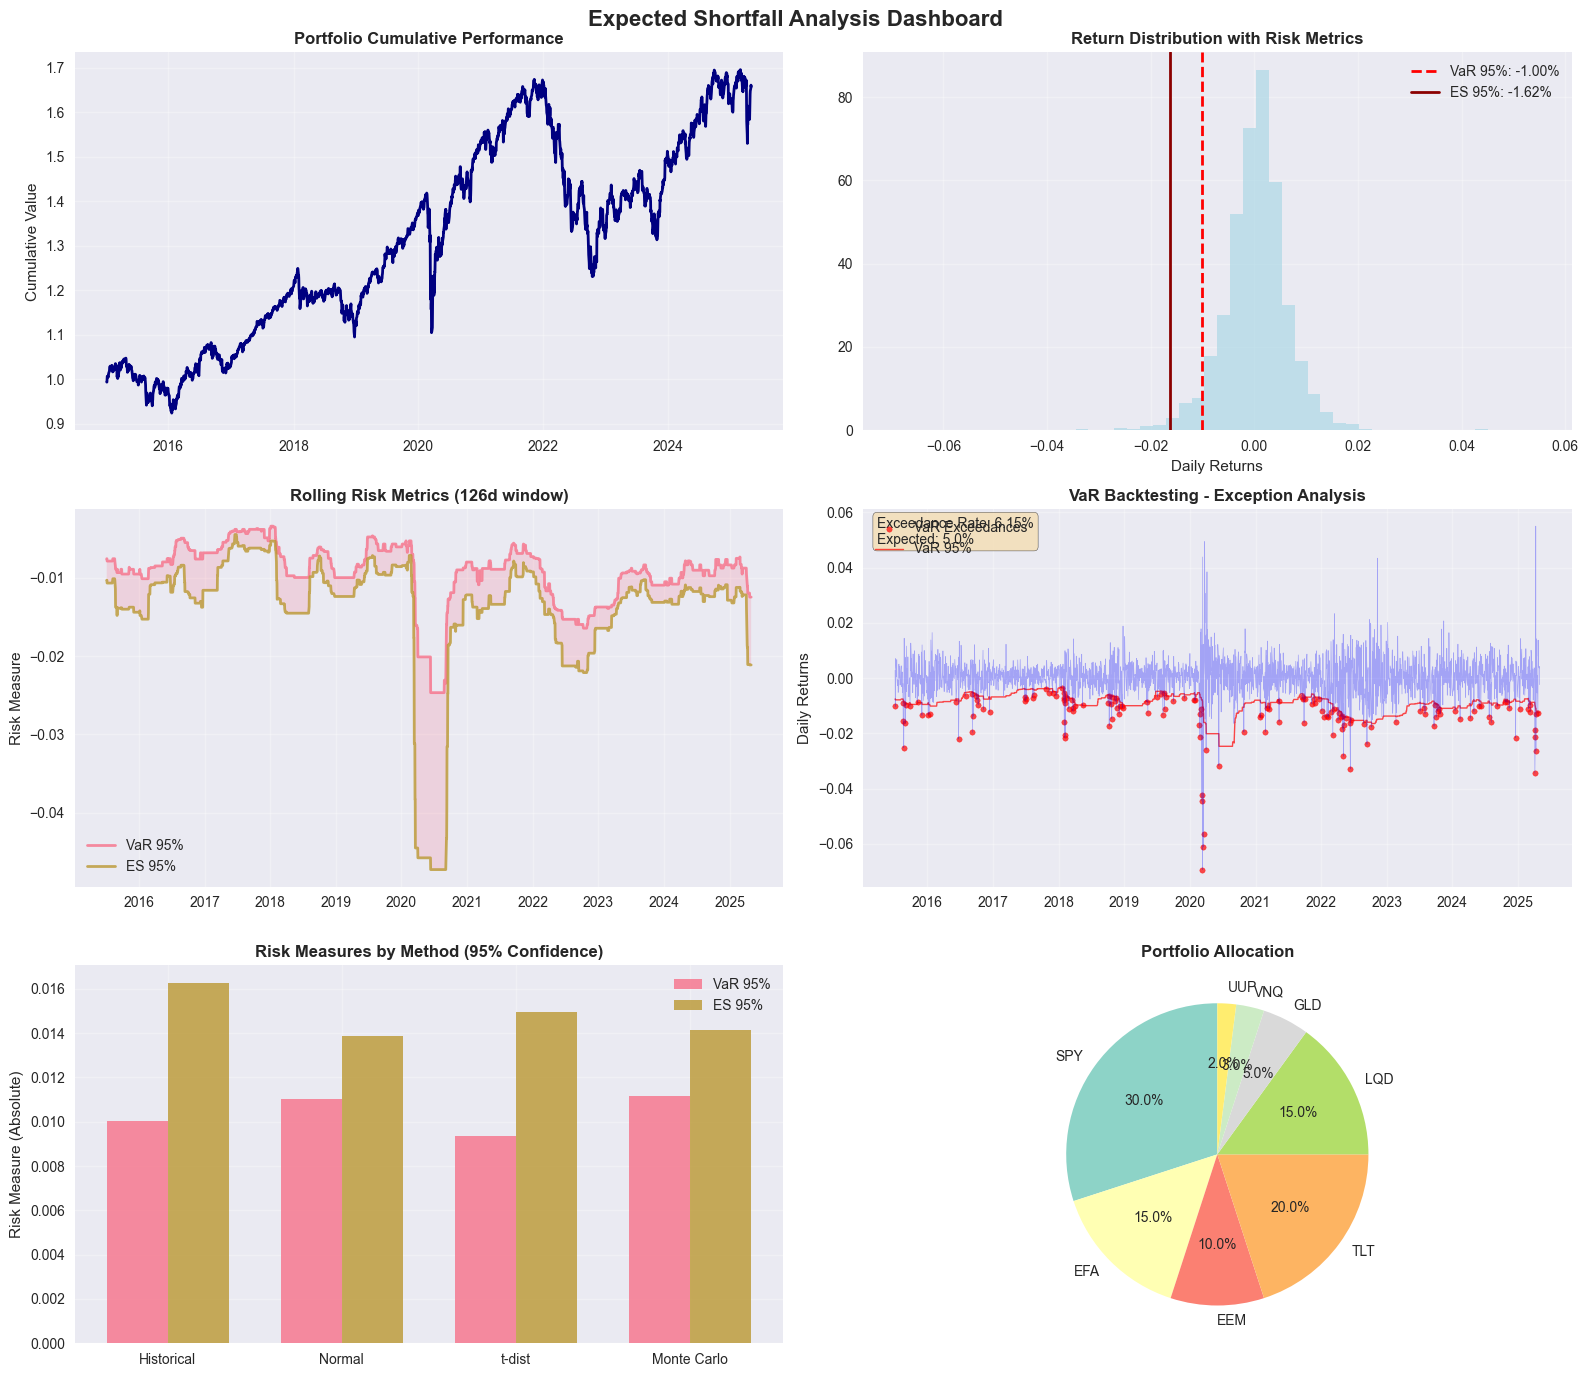

In [24]:
print(f"\n" + "="*50)
print("CREATING VISUALIZATIONS")
print("="*50)

# Create comprehensive visualization
fig, axes = plt.subplots(3, 2, figsize=(16, 14))
fig.suptitle('Expected Shortfall Analysis Dashboard', fontsize=16, fontweight='bold')

# 1. Portfolio cumulative returns
axes[0, 0].plot(portfolio_returns.index, (1 + portfolio_returns).cumprod(), 
                linewidth=2, color='navy')
axes[0, 0].set_title('Portfolio Cumulative Performance', fontweight='bold')
axes[0, 0].set_ylabel('Cumulative Value')
axes[0, 0].grid(True, alpha=0.3)

# 2. Return distribution with VaR/ES overlay
axes[0, 1].hist(portfolio_returns, bins=50, alpha=0.7, density=True, color='lightblue')
var_95 = es_results['historical']['95%']['VaR']
es_95 = es_results['historical']['95%']['ES']
axes[0, 1].axvline(var_95, color='red', linestyle='--', linewidth=2, label=f'VaR 95%: {var_95:.2%}')
axes[0, 1].axvline(es_95, color='darkred', linestyle='-', linewidth=2, label=f'ES 95%: {es_95:.2%}')
axes[0, 1].set_title('Return Distribution with Risk Metrics', fontweight='bold')
axes[0, 1].set_xlabel('Daily Returns')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Rolling VaR vs ES
axes[1, 0].plot(rolling_results.index, rolling_results['var'], 
                label='VaR 95%', linewidth=2, alpha=0.8)
axes[1, 0].plot(rolling_results.index, rolling_results['es'], 
                label='ES 95%', linewidth=2, alpha=0.8)
axes[1, 0].fill_between(rolling_results.index, rolling_results['var'], 
                       rolling_results['es'], alpha=0.2)
axes[1, 0].set_title(f'Rolling Risk Metrics ({rolling_window}d window)', fontweight='bold')
axes[1, 0].set_ylabel('Risk Measure')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. VaR backtesting - exceedances
exceedances = rolling_results['return'] < rolling_results['var']
axes[1, 1].scatter(rolling_results.index[exceedances], 
                  rolling_results['return'][exceedances], 
                  alpha=0.7, s=15, color='red', label='VaR Exceedances')
axes[1, 1].plot(rolling_results.index, rolling_results['var'], 
               color='red', alpha=0.7, linewidth=1, label='VaR 95%')
axes[1, 1].plot(rolling_results.index, rolling_results['return'], 
               color='blue', alpha=0.3, linewidth=0.5)
axes[1, 1].set_title('VaR Backtesting - Exception Analysis', fontweight='bold')
axes[1, 1].set_ylabel('Daily Returns')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Calculate exceedance rate
exceedance_rate = exceedances.sum() / len(exceedances)
expected_rate = 0.05  # 5% for 95% VaR
axes[1, 1].text(0.02, 0.98, f'Exceedance Rate: {exceedance_rate:.2%}\nExpected: {expected_rate:.1%}', 
               transform=axes[1, 1].transAxes, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# 5. Method comparison
methods_short = ['Historical', 'Normal', 't-dist', 'Monte Carlo']
var_values = [es_results[k]['95%']['VaR'] for k in ['historical', 'parametric_normal', 'parametric_t', 'monte_carlo']]
es_values = [es_results[k]['95%']['ES'] for k in ['historical', 'parametric_normal', 'parametric_t', 'monte_carlo']]

x = np.arange(len(methods_short))
width = 0.35

bars1 = axes[2, 0].bar(x - width/2, np.abs(var_values), width, label='VaR 95%', alpha=0.8)
bars2 = axes[2, 0].bar(x + width/2, np.abs(es_values), width, label='ES 95%', alpha=0.8)

axes[2, 0].set_title('Risk Measures by Method (95% Confidence)', fontweight='bold')
axes[2, 0].set_ylabel('Risk Measure (Absolute)')
axes[2, 0].set_xticks(x)
axes[2, 0].set_xticklabels(methods_short)
axes[2, 0].legend()
axes[2, 0].grid(True, alpha=0.3)

# 6. Portfolio composition
if es_engine.weights:
    assets = list(es_engine.weights.keys())
    weights = list(es_engine.weights.values())
    colors = plt.cm.Set3(np.linspace(0, 1, len(assets)))
    
    wedges, texts, autotexts = axes[2, 1].pie(weights, labels=assets, autopct='%1.1f%%',
                                             colors=colors, startangle=90)
    axes[2, 1].set_title('Portfolio Allocation', fontweight='bold')

plt.tight_layout()
plt.show()

## Summary and Key Takeaways


In [25]:
print(f"\n" + "="*60)
print("ANALYSIS SUMMARY & KEY TAKEAWAYS")
print("="*60)

print(f"""
🎯 PORTFOLIO PERFORMANCE:
   • Annualized Return: {portfolio_stats['Annualized Return']:.2%}
   • Annualized Volatility: {portfolio_stats['Annualized Volatility']:.2%}
   • Sharpe Ratio: {portfolio_stats['Sharpe Ratio']:.2f}

📊 RISK METRICS (95% Confidence):
   • Historical VaR: {es_results['historical']['95%']['VaR']:.2%}
   • Historical ES: {es_results['historical']['95%']['ES']:.2%}
   • ES/VaR Ratio: {es_results['historical']['95%']['ES_VaR_Ratio']:.2f}

⚠️  STRESS TEST HIGHLIGHTS:
""")

for scenario, metrics in stress_results.items():
    print(f"   • {scenario}: ES 95% = {metrics['ES_95%']:.2%}")

print(f"""
🔍 METHODOLOGY INSIGHTS:
   1. Expected Shortfall provides more information than VaR about tail losses
   2. Historical simulation captures actual market behavior
   3. Parametric methods may underestimate crisis-period risks
   4. Rolling analysis reveals time-varying risk patterns
   5. Stress testing validates model performance in extreme scenarios

📈 NEXT STEPS FOR RiskAlphaEngine:
   1. Implement component Expected Shortfall for risk attribution
   2. Add filtered historical simulation with GARCH models
   3. Develop ES-based position sizing algorithms
   4. Create automated backtesting framework
   5. Integrate with volatility forecasting models
""")

print("✅ Expected Shortfall analysis complete!")
print("📝 Ready for integration into RiskAlphaEngine framework")


ANALYSIS SUMMARY & KEY TAKEAWAYS

🎯 PORTFOLIO PERFORMANCE:
   • Annualized Return: 5.49%
   • Annualized Volatility: 10.85%
   • Sharpe Ratio: 0.51

📊 RISK METRICS (95% Confidence):
   • Historical VaR: -1.00%
   • Historical ES: -1.62%
   • ES/VaR Ratio: 1.62

⚠️  STRESS TEST HIGHLIGHTS:

   • COVID Crash: ES 95% = -5.78%
   • Dec 2018 Selloff: ES 95% = -1.28%
   • Rate Hike Fears: ES 95% = -2.12%

🔍 METHODOLOGY INSIGHTS:
   1. Expected Shortfall provides more information than VaR about tail losses
   2. Historical simulation captures actual market behavior
   3. Parametric methods may underestimate crisis-period risks
   4. Rolling analysis reveals time-varying risk patterns
   5. Stress testing validates model performance in extreme scenarios

📈 NEXT STEPS FOR RiskAlphaEngine:
   1. Implement component Expected Shortfall for risk attribution
   2. Add filtered historical simulation with GARCH models
   3. Develop ES-based position sizing algorithms
   4. Create automated backtestin